In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score
from sklearn import preprocessing
#from tensorflow import keras
#from tensorflow.keras import layers
#from keras.layers import Dense, SimpleRNN, LSTM, Dropout
#from keras import Input
#from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import statsmodels.api as sm

# Gives warning bug see: https://github.com/pandas-dev/pandas/issues/39554
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Whether to read realistic data file or nooutliers data file. 
df = pd.read_csv('realistic_data.csv')
#df = pd.read_csv('nooutliers_data.csv')

# Whether to plot everything or not
PLOT_EDA2 = False

In [2]:
# Create columns for variables that have a value
for var in df["variable"].unique():
    df['%s'%var] = np.where(df['variable'] == var, df['value'], np.NaN)

# Split the date-time in seperate columns, transform to a datetime format
df[['date', 'time']] = df['time'].str.split(' ', 1, expand=True)
df['time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S.%f')

# Print example
df.head()

,Unnamed: 0,index,Unnamed: 0.1,id,time,variable,value,mood,circumplex.arousal,circumplex.valence,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,date
0,0,0,1,1,2014-02-26 13:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
1,1,1,2,1,2014-02-26 15:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
2,2,2,3,1,2014-02-26 18:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
3,3,3,4,1,2014-02-26 21:00:00,mood,7.0,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
4,4,4,5,1,2014-02-27 09:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-27


In [3]:
# Pick one sample user

def create_merged_dataset(df):
    frames = []
    unique_users = df['id'].unique()
    for uu in unique_users:
        df1 = df[df['id'] == uu]
        df_avg = pd.DataFrame()

        # Average over the day
        take_mean = set(("mood", "activity", "circumplex.arousal", "circumplex.valence"))

        # Total time everyday
        take_sum = set(("screen", "appCat.builtin","appCat.communication","appCat.entertainment", 
                        "appCat.finance", "appCat.game", "appCat.office", "appCat.other", "appCat.social",  
                        "appCat.travel", "appCat.unknown", "appCat.utilities", "appCat.weather"))

        # Amount of calls or texts a day
        take_count = set(("call", "sms"))

        for var in df["variable"].unique():
            df2 = df1[df1[var].notna()]
            if var in take_mean:
                df_mean = df2.groupby('date').mean()
                df_avg[var] = df_mean[var]
            if var in take_sum:
                df_sum = df2.groupby('date').mean()
                df_avg[var] = df_sum[var]
            if var in take_count:
                df_count = df2.groupby('date').count()
                df_avg[var] = df_count[var]
        
        df_avg["id"] = uu
        
        # Provide benchmark mood by taking mood from day before
        df_avg["Benchmark_mood_pred"] = df_avg.mood.shift(1)
        
        frames.append(df_avg)
        

    df_merged = pd.concat(frames)
    col = df_merged.pop("id")
    df_merged.insert(0, col.name, col)
    return df_merged

df_merged = create_merged_dataset(df)
#print('Dataset with all id, not yet aggregated the values for different time periods')
dfa1401 = df_merged[df_merged['id']=='AS14.01']
print('length of merged dataset:', len(df_merged))
print(df_merged.isna().sum())
df_merged.head()

length of merged dataset: 1268
id                         0
mood                       0
circumplex.arousal         0
circumplex.valence         2
activity                 118
screen                   100
call                     528
sms                      840
appCat.builtin           111
appCat.communication     121
appCat.entertainment     445
appCat.finance          1062
appCat.game             1079
appCat.office            998
appCat.other             165
appCat.social            306
appCat.travel            850
appCat.unknown          1013
appCat.utilities         844
appCat.weather          1157
Benchmark_mood_pred       27
dtype: int64


,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,-0.25,0.750000,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-27,1,6.333333,0.00,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.250000
2014-03-21,1,6.200000,0.20,0.200000,0.134050,81.254545,6.0,NaN,5.962021,47.019804,...,3.8294,NaN,57.402,29.968875,64.902404,39.064,NaN,11.32795,NaN,6.333333
2014-03-22,1,6.400000,0.60,0.500000,0.236880,35.787491,3.0,1.0,4.530716,36.687838,...,6.5255,NaN,NaN,14.020429,25.252900,37.305,NaN,39.20700,NaN,6.200000
2014-03-23,1,6.800000,0.20,0.800000,0.142741,56.007602,NaN,NaN,5.342474,45.717667,...,11.4110,NaN,NaN,12.137167,47.533333,NaN,NaN,30.08600,30.386,6.400000


In [4]:
# change NaN to 0
df = df_merged.replace(np.nan, 0)

# Normalize circumplex values using min-max normalization
df['circumplex.arousal'] =(df['circumplex.arousal']-df['circumplex.arousal'].min())/(df['circumplex.arousal'].max()-df['circumplex.arousal'].min())
df['circumplex.valence'] = (df['circumplex.valence']-df['circumplex.valence'].min())/(df['circumplex.valence'].max()-df['circumplex.valence'].min())

# Use sqrt transformation
no_mood = df.loc[:, (df.columns != 'mood') | 
                    (df.columns != 'id') | 
                    (df.columns != "Benchmark_mood_pred")].columns
print(no_mood)
no_mood = ['circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']

# Use sqrt sqrt transformation
df[no_mood] = np.sqrt(df[no_mood])
df[no_mood] = np.sqrt(df[no_mood])

# Replace zero's for very small values - remove 2 zero's to get better view
df = df.replace(0, 0.00000001)
df

Index(['id', 'mood', 'circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather',
       'Benchmark_mood_pred'],
      dtype='object')


,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,8.132883e-01,0.885700,1.000000e-08,1.000000e-08,1.000000e+00,1.189207e+00,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
2014-02-27,1,6.333333,8.408964e-01,0.835453,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,6.250000e+00
2014-03-21,1,6.200000,8.611735e-01,0.817281,6.050856e-01,3.002354e+00,1.565085e+00,1.000000e-08,1.562602e+00,2.618606e+00,...,1.398887e+00,1.000000e-08,2.752528e+00,2.339740e+00,2.838345e+00,2.500024e+00,1.000000e-08,1.834585e+00,1.000000e-08,6.333333e+00
2014-03-22,1,6.400000,8.979008e-01,0.856621,6.976413e-01,2.445867e+00,1.316074e+00,1.000000e+00,1.458954e+00,2.461107e+00,...,1.598282e+00,1.000000e-08,1.000000e-08,1.935042e+00,2.241702e+00,2.471393e+00,1.000000e-08,2.502309e+00,1.000000e-08,6.200000e+00
2014-03-23,1,6.800000,8.611735e-01,0.891185,6.146633e-01,2.735658e+00,1.000000e-08,1.000000e-08,1.520322e+00,2.600285e+00,...,1.837938e+00,1.000000e-08,1.000000e-08,1.866506e+00,2.625727e+00,1.000000e-08,1.000000e-08,2.342023e+00,2.347839e+00,6.400000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,33,6.200000,7.691606e-01,0.844112,3.357277e-01,3.106083e+00,1.000000e+00,1.189207e+00,1.438745e+00,2.680415e+00,...,1.000000e-08,1.000000e-08,1.000000e-08,2.055052e+00,2.281373e+00,1.000000e-08,1.000000e-08,1.000250e+00,1.000000e-08,5.400000e+00
2014-05-28,33,8.200000,8.408964e-01,0.931796,5.669259e-01,2.965266e+00,1.778279e+00,1.000000e+00,1.537597e+00,2.327737e+00,...,1.000000e-08,1.000000e-08,2.528221e+00,2.201263e+00,2.774436e+00,1.000000e-08,1.000000e-08,1.503580e+00,1.000000e-08,6.200000e+00
2014-05-29,33,7.000000,6.389431e-01,0.912168,6.415037e-01,2.862369e+00,1.495349e+00,1.000000e+00,1.529362e+00,2.654587e+00,...,1.000000e-08,1.000000e-08,1.000000e-08,1.766334e+00,3.664780e+00,9.843882e-01,1.000000e-08,1.124595e+00,1.000000e-08,8.200000e+00


In [5]:
def print_plot_eda2(df):
    # distribution plots of all variables
    df.hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8);
    
    # only valence correlated, however nothing done with outliers
    df_avg_corr = df.corr()['mood'][1:]
    golden_features_list = df_avg_corr[abs(df_avg_corr) > 0.4].sort_values(ascending=False)
    print("There is {} strongly correlated values with mood:\n{}".format(len(golden_features_list), golden_features_list))
    
    # scatterplots of all variables against mood
    for i in range(1, len(df.columns)+1, 5):
        sns.pairplot(data=df,
                    x_vars=df.columns[i:i+5],
                    y_vars=['mood'])
        
    # call correlates 1 on 1 with  app unknown and sms 1 on 1 with app office
    corr = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], 
                cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
                annot=True, annot_kws={"size": 8}, square=True);
    
    features_to_analyse = [x for x in df.columns if x in golden_features_list]
    print('features to analyse:', features_to_analyse)
    
    ''' fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

    for i, ax in enumerate(fig.axes):
        if i < len(features_to_analyse) - 1:
            sns.regplot(x=features_to_analyse[i],y='mood', data=df[features_to_analyse], ax=ax)'''
    
    return

if PLOT_EDA2:
    print_plot_eda2(df)

df

,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,8.132883e-01,0.885700,1.000000e-08,1.000000e-08,1.000000e+00,1.189207e+00,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
2014-02-27,1,6.333333,8.408964e-01,0.835453,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,6.250000e+00
2014-03-21,1,6.200000,8.611735e-01,0.817281,6.050856e-01,3.002354e+00,1.565085e+00,1.000000e-08,1.562602e+00,2.618606e+00,...,1.398887e+00,1.000000e-08,2.752528e+00,2.339740e+00,2.838345e+00,2.500024e+00,1.000000e-08,1.834585e+00,1.000000e-08,6.333333e+00
2014-03-22,1,6.400000,8.979008e-01,0.856621,6.976413e-01,2.445867e+00,1.316074e+00,1.000000e+00,1.458954e+00,2.461107e+00,...,1.598282e+00,1.000000e-08,1.000000e-08,1.935042e+00,2.241702e+00,2.471393e+00,1.000000e-08,2.502309e+00,1.000000e-08,6.200000e+00
2014-03-23,1,6.800000,8.611735e-01,0.891185,6.146633e-01,2.735658e+00,1.000000e-08,1.000000e-08,1.520322e+00,2.600285e+00,...,1.837938e+00,1.000000e-08,1.000000e-08,1.866506e+00,2.625727e+00,1.000000e-08,1.000000e-08,2.342023e+00,2.347839e+00,6.400000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,33,6.200000,7.691606e-01,0.844112,3.357277e-01,3.106083e+00,1.000000e+00,1.189207e+00,1.438745e+00,2.680415e+00,...,1.000000e-08,1.000000e-08,1.000000e-08,2.055052e+00,2.281373e+00,1.000000e-08,1.000000e-08,1.000250e+00,1.000000e-08,5.400000e+00
2014-05-28,33,8.200000,8.408964e-01,0.931796,5.669259e-01,2.965266e+00,1.778279e+00,1.000000e+00,1.537597e+00,2.327737e+00,...,1.000000e-08,1.000000e-08,2.528221e+00,2.201263e+00,2.774436e+00,1.000000e-08,1.000000e-08,1.503580e+00,1.000000e-08,6.200000e+00
2014-05-29,33,7.000000,6.389431e-01,0.912168,6.415037e-01,2.862369e+00,1.495349e+00,1.000000e+00,1.529362e+00,2.654587e+00,...,1.000000e-08,1.000000e-08,1.000000e-08,1.766334e+00,3.664780e+00,9.843882e-01,1.000000e-08,1.124595e+00,1.000000e-08,8.200000e+00


In [6]:
## Transform data period based on delta 5 timeperiod
delta = 5

# See https://sparkbyexamples.com/pandas/pandas-rolling-mean-average-sum/

pd.options.mode.chained_assignment = None  # default='warn'

def merge_on_delta(df,delta):
    frames = []
    unique_users = df['id'].unique()
    for uu in unique_users:
        df_user = df[df['id']==uu]
        
        # Get moving average of all columns except target / benchmark column mood
        df_user['ma_mood'] = df_user['mood']
        no_mood = df_user.loc[:, (df_user.columns != 'mood') | 
                    (df_user.columns != 'id') | 
                    (df_user.columns != "Benchmark_mood_pred")].columns
        
        # Average over delta days
        take_mean = ["ma_mood", "activity", "circumplex.arousal", "circumplex.valence"]
         # Total time over delta days
        take_sum = ["screen", "appCat.builtin","appCat.communication","appCat.entertainment", 
                        "appCat.finance", "appCat.game", "appCat.office", "appCat.other", "appCat.social",  
                        "appCat.travel", "appCat.unknown", "appCat.utilities", "appCat.weather"]

        # Amount of calls or texts every delta days
        take_count = ["call", "sms"]
        
        
        df_user.loc[:, take_mean] = df_user[take_mean].rolling(window=delta).mean()
        df_user.loc[:, take_sum] = df_user[take_sum].rolling(window=delta).sum()
        df_user.loc[:, take_count] = df_user[take_count].rolling(window=delta).sum()
        
        
        # Also make moving average excluding current column. We shift all columns 1 step down except the target mood + id numbers
        df_user.loc[:, (df_user.columns != 'mood') | 
                    (df_user.columns != 'id') | 
                    (df_user.columns != '"Benchmark_mood_pred"')] = df_user.loc[:, (df_user.columns != 'mood') 
                                                                                | (df_user.columns != 'id')
                                                                                | (df_user.columns != '"Benchmark_mood_pred"')].shift(1)
        
        # Rename index
        df_user.index.names = ['EndDateDelta%s'%delta]
        frames.append(df_user)
    df_merged = pd.concat(frames)
    col = df_merged.pop("id")
    df_merged.insert(0, col.name, col)
    
    # Drop all rows that are from period < delta
    df_merged = df_merged.dropna()
    return df_merged

# Save data for temporal model (see lower cells)
df_no_delta = df


df = merge_on_delta(df, delta)
df

,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred,ma_mood
EndDateDelta5,,,,,,,,,,,,,,,,,,,,,
2014-03-24,1.0,6.80,0.854887,0.857248,0.383478,8.183879,5.0,5.0,4.541878,7.679999,...,5.000000e-08,2.752528,6.141287,7.705774,4.971417e+00,5.000000e-08,6.678917,2.347839e+00,6.40,6.396667
2014-03-25,1.0,6.00,0.875167,0.837610,0.489497,10.663987,5.0,5.0,5.997835,10.019686,...,5.000000e-08,4.069697,7.966285,10.369488,6.691373e+00,5.000000e-08,9.753548,2.347839e+00,6.80,6.346667
2014-03-26,1.0,6.75,0.884816,0.841844,0.601505,13.368852,5.0,5.0,7.551523,12.461727,...,5.000000e-08,4.069697,10.302784,13.056310,6.691373e+00,2.346738e+00,11.948316,2.347839e+00,6.00,6.430000
2014-03-27,1.0,6.60,0.876388,0.852108,0.593322,12.899077,5.0,5.0,7.532676,12.237611,...,5.000000e-08,1.317169,9.970801,13.194505,4.191349e+00,2.346738e+00,12.517113,2.347839e+00,6.75,6.510000
2014-03-28,1.0,7.00,0.869043,0.859021,0.580188,12.980950,5.0,5.0,7.565130,12.111079,...,5.000000e-08,3.256335,9.803060,13.848807,3.925370e+00,2.346738e+00,11.883257,2.347839e+00,6.60,6.630000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,33.0,5.40,0.782930,0.811790,0.453750,15.425412,5.0,5.0,7.968749,11.846219,...,5.000000e-08,3.380085,9.736541,13.851881,5.000000e-08,5.000000e-08,3.073308,5.000000e-08,6.25,5.926667
2014-05-28,33.0,6.20,0.758934,0.815765,0.455347,15.548897,5.0,5.0,7.775942,12.193601,...,5.000000e-08,3.380085,9.758636,13.655346,5.000000e-08,5.000000e-08,2.692678,5.000000e-08,5.40,6.016667
2014-05-29,33.0,8.20,0.780135,0.844622,0.492974,14.986636,5.0,5.0,7.687571,12.077920,...,5.000000e-08,5.908306,9.987645,12.977286,5.000000e-08,5.000000e-08,4.196258,5.000000e-08,6.20,6.490000


In [7]:
benchmark_test_mse = mean_squared_error(df['mood'], df['Benchmark_mood_pred'])
benchmark_test_mae = mean_absolute_error(df['mood'], df['Benchmark_mood_pred'])

print("Benchmark test mse = ",benchmark_test_mse," & mae = ",benchmark_test_mae," & rmse = ", sqrt(benchmark_test_mse))

Benchmark test mse =  0.5644709228204374  & mae =  0.54783759929391  & rmse =  0.7513127995851245


0.00393746103954226
R squared training set 24.58
R squared test set 21.96
MSE training set 0.38
MSE test set 0.49
[(0.008493150135679507, 'circumplex.arousal'), (0.2777583253862314, 'circumplex.valence'), (-0.0, 'activity'), (-0.12834855776949136, 'screen'), (0.0, 'call'), (0.0, 'sms'), (0.059640677557333044, 'appCat.builtin'), (0.08829167783597969, 'appCat.communication'), (-0.05162776927368637, 'appCat.entertainment'), (0.0013878514536072675, 'appCat.finance'), (0.07817599118344094, 'appCat.game'), (0.0294967998311591, 'appCat.office'), (0.07252049063332063, 'appCat.other'), (-0.0796693395699526, 'appCat.social'), (0.05641297921626146, 'appCat.travel'), (-0.034937242035986034, 'appCat.unknown'), (0.01948696625279838, 'appCat.utilities'), (0.04367632218448812, 'appCat.weather')]
['call', 'sms', 'circumplex.valence', 'appCat.game', 'appCat.travel', 'appCat.entertainment', 'appCat.builtin', 'screen', 'appCat.communication']
['circumplex.valence', 'screen', 'appCat.builtin', 'appCat.comm

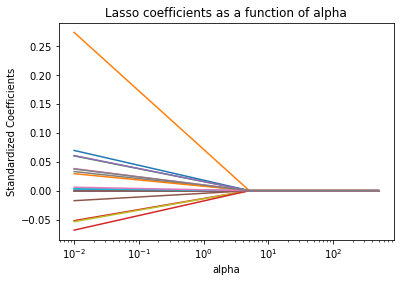

In [8]:
# feature selection
att_select = ['circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']


# split data
X_train, X_test, y_train, y_test = train_test_split(df[att_select], df['mood'], test_size=0.3, random_state=10)

# standardize data
scaler = StandardScaler().fit(X_train[att_select]) 
X_train[att_select] = scaler.transform(X_train[att_select])
X_test[att_select] = scaler.transform(X_test[att_select])

# Lasso with 5 fold cross-validation to find best alpha
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)
print(model.alpha_)

# lasso
reg = Lasso(alpha=model.alpha_)
reg.fit(X_train, y_train)

# results
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

print(list(zip(reg.coef_, att_select)))


alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

# lasso att has all attributes except for utilities
lasso_att = ['circumplex.arousal', 'circumplex.valence', 
       'screen', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']

# blocks warning from distplot, since it will soon be depreciated 
import warnings
warnings.filterwarnings('ignore')

def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features,dtype=None)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

features_forward = forward_selection(df[att_select],df['mood'])
print(features_forward)
features_back = backward_elimination(df[att_select],df['mood'])
print(features_back)

In [9]:
#----------%KNN%----------------------------------------------------------------

In [10]:
#kNn per user
unique_users = df['id'].unique()
MSE_list_knn = []
MAE_list_knn = []

for uu in unique_users:
    df_u = df[df['id'] == uu]
    attributes = ['circumplex.arousal', 'circumplex.valence', 'activity',
           'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
           'appCat.entertainment', 'appCat.finance', 'appCat.game',
           'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
           'appCat.unknown', 'appCat.utilities', 'appCat.weather']
    X = df_u[features_back]
    y = df_u[['mood']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    knn_model = KNeighborsRegressor(n_neighbors=12)
    knn_model.fit(X_train, y_train)

    train_preds = knn_model.predict(X_train)
    mse = mean_squared_error(y_train, train_preds)
    test_preds = knn_model.predict(X_test)
    mse_test = mean_squared_error(y_test, test_preds)
    MSE_list_knn.append(mse_test)

    knn_mse = mean_squared_error(y_train, train_preds)
    knn_mae = mean_absolute_error(y_train, train_preds)
    #print("kNN training mse = ",knn_mse," & mae = ",knn_mae," & rmse = ", sqrt(knn_mse))
    
    knn_test_mse = mean_squared_error(y_test, test_preds)
    knn_test_mae = mean_absolute_error(y_test, test_preds)
    MAE_list_knn.append(knn_test_mae)
    #print("kNN test mse = ",knn_test_mse," & mae = ",knn_test_mae," & rmse = ", sqrt(knn_test_mse))

Text(0, 0.5, 'mean squared error')

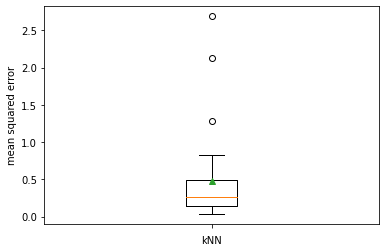

In [11]:
plt.boxplot(MSE_list_knn, showmeans = True)
plt.xlabel('kNN')
plt.xticks([1], [''])
plt.ylabel('mean squared error')

In [12]:
#kNN for all users together

attributes = ['circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.weather', 'appCat.utilities']
X = df[attributes]
y = df[['mood']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

knn_model = KNeighborsRegressor(n_neighbors=15)
knn_model.fit(X_train, y_train)

train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
test_preds = knn_model.predict(X_test)
mse_test = mean_squared_error(y_test, test_preds)

knn_mse = mean_squared_error(y_train, train_preds)
knn_mae = mean_absolute_error(y_train, train_preds)
print("kNN training mse = ",knn_mse," & mae = ",knn_mae," & rmse = ", sqrt(knn_mse))

knn_test_mse = mean_squared_error(y_test, test_preds)
knn_test_mae = mean_absolute_error(y_test, test_preds)

print("kNN test mse = ",knn_test_mse," & mae = ",knn_test_mae," & rmse = ", sqrt(knn_test_mse))

kNN training mse =  0.32043901152808435  & mae =  0.41426661761098843  & rmse =  0.5660733269887254
kNN test mse =  1.0418909827595577  & mae =  0.8046940773372488  & rmse =  1.0207306122378998


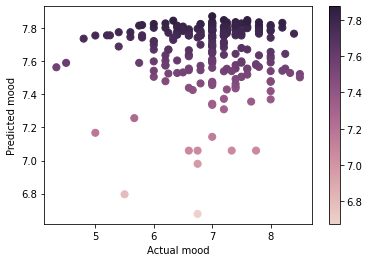

In [13]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(y_test, test_preds, c=test_preds, s=50, cmap=cmap)
ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
f.colorbar(points)
plt.show()

In [14]:
#Nested Cross Validation kNN
MSE_list_cv = []
MAE_list_cv =[]

attributes = ['circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.weather', 'appCat.utilities', 'ma_mood']

X, y = df[attributes], df[['mood']]

seeds = list(range(100,201,1))
tic = time.perf_counter()
for i in seeds:
    cv_outer = KFold(n_splits=10, shuffle=True, random_state=i)
    for train_i, val_i in cv_outer.split(X, y):
        X_train, X_val = X.iloc[train_i,:], X.iloc[val_i,:]
        y_train, y_val = y.iloc[train_i,:], y.iloc[val_i,:]
        
        knn_model = KNeighborsRegressor(n_neighbors = 12)
        knn_model.fit(X_train, y_train)
        
        test_preds = knn_model.predict(X_val)
        mse_test = mean_squared_error(y_val, test_preds)
        mae_test = mean_absolute_error(y_val, test_preds)
        
        MSE_list_cv.append(mse_test)
        MAE_list_cv.append(mae_test)

toc = time.perf_counter()
print(f"Nested cross validation for kNN took {toc - tic:0.4f} seconds")
print('Mean MSE: %.3f (%.3f)' % (np.mean(MSE_list_cv), np.std(MSE_list_cv)))
print('Mean MAE: %.3f (%.3f)' % (np.mean(MAE_list_cv), np.std(MAE_list_cv)))

Nested cross validation for kNN took 12.5175 seconds
Mean MSE: 0.393 (0.073)
Mean MAE: 0.464 (0.038)


1010


Text(0.5, 1.0, 'kNN Cross Validation ')

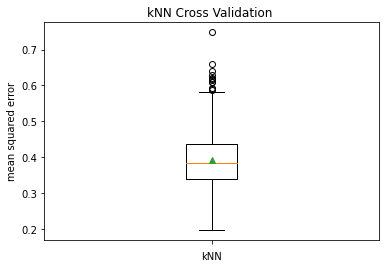

In [15]:
print(len(MSE_list_cv))
plt.boxplot(MSE_list_cv, showmeans = True)
plt.xlabel('kNN')
plt.xticks([1], [''])
plt.ylabel('mean squared error')
plt.title('kNN Cross Validation ')

In [16]:
attributes = ['circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.weather', 'appCat.utilities', 'ma_mood']
X = df[attributes]
y = df[['mood']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train.values.ravel())
train_preds = rf_model.predict(X_train)

rf_mse = mean_squared_error(y_train, train_preds)
rf_mae = mean_absolute_error(y_train, train_preds)
print("Random Forest training mse = ",rf_mse," & mae = ",rf_mae," & rmse = ", sqrt(rf_mse))

test_preds = rf_model.predict(X_test)

rf_test_mse = mean_squared_error(y_test, test_preds)
rf_test_mae = mean_absolute_error(y_test, test_preds)

print("Random Forest test mse = ",rf_test_mse," & mae = ",rf_test_mae," & rmse = ", sqrt(rf_test_mse))

Random Forest training mse =  0.04763870885454989  & mae =  0.15743524650478305  & rmse =  0.21826293513684336
Random Forest test mse =  0.353306563876652  & mae =  0.4469574155653449  & rmse =  0.5943959655622268


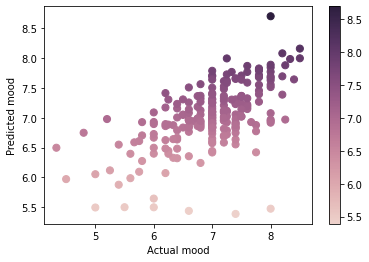

In [17]:
#RF plot
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(y_test, test_preds, c=test_preds, s=50, cmap=cmap)
ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
f.colorbar(points)
plt.show()

In [ ]:
#RF with nested CV

MSE_list_cv_rf = []
MAE_list_cv_rf =[]
run = 0
attributes =['circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']

X, y = df[attributes], df[['mood']]

n_splits = 10 

seeds = list(range(100,201,1))
tic = time.perf_counter()
for i in seeds:
    cv_outer = KFold(n_splits=n_splits, shuffle=True, random_state=i)
    for train_i, val_i in cv_outer.split(X, y):
        X_train, X_val = X.iloc[train_i,:], X.iloc[val_i,:]
        y_train, y_val = y.iloc[train_i,:], y.iloc[val_i,:]
        #scaler = preprocessing.StandardScaler().fit(X_train)
        #X_train = scaler.transform(X_train)
        #X_val = scaler.transform(X_val)
        
        rf_model = RandomForestRegressor()
        rf_model.fit(X_train, y_train.values.ravel())
        
        test_preds = rf_model.predict(X_val)

        rf_test_mse = mean_squared_error(y_val, test_preds)
        rf_test_mae = mean_absolute_error(y_val, test_preds)
        
        MSE_list_cv_rf.append(rf_test_mse)
        MAE_list_cv_rf.append(rf_test_mae)
        
        run += 1
        if run == round(n_splits * 101 / 4):
            print("25% done!")
        elif run == round(n_splits * 101 / 2):
            print("50% done!")
        elif run == round(n_splits * 101 * 0.75):
            print("75% done!")
toc = time.perf_counter()
print(f"Nested cross validation for Random Forest took {toc - tic:0.4f} seconds")
print('Mean MSE for RF with nested CV: %.6f (%.6f)' % (np.mean(MSE_list_cv_rf), np.std(MSE_list_cv_rf)))
print('Mean MAE for RF with nested CV: %.6f (%.6f)' % (np.mean(MAE_list_cv_rf), np.std(MAE_list_cv_rf)))

25% done!


In [ ]:
print('Mean MSE for RF with nested CV: %.7f (%.7f)' % (np.mean(MSE_list_cv_rf), np.std(MSE_list_cv_rf)))
print('Mean MAE for RF with nested CV: %.7f (%.7f)' % (np.mean(MAE_list_cv_rf), np.std(MAE_list_cv_rf)))

In [ ]:
plt.boxplot(MSE_list_cv_rf, showmeans = True)
plt.xlabel('RF')
plt.xticks([1], [''])
plt.ylabel('mean squared error')
plt.title('RF Cross Validation ')

In [ ]:
# ARIMA example
from statsmodels.tsa.arima.model import ARIMA
from random import random

df_user1 = df_no_delta[df_no_delta['id']==1]
data1 = df_user1['mood'].values


model = ARIMA(data1, order=(1, 1, 1))
model_fit = model.fit()
# make prediction
predictions = model_fit.predict()

f, ax = plt.subplots()
x = df_user1['mood'].index

plt.plot(x, df_user1['mood'], label='actual')
plt.plot(x, predictions, label='forecast')
plt.xlabel('Time')
plt.ylabel('Mood')
ymin, ymax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(ymin, ymax, 6), 2))
plt.title("ARIMA")
plt.legend()

arima_test_mse = mean_squared_error(df_user1['mood'].values, predictions)
arima_test_mae = mean_absolute_error(df_user1['mood'].values, predictions)
plt.title("ARIMA")

print("ARIMA test mse = ",arima_test_mse," & mae = ",arima_test_mae," & rmse = ", sqrt(arima_test_mse))

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()

MSE_list = []
MAE_list = []
unique_users = df_no_delta['id'].unique()
for uu in unique_users:
    df_u = df_no_delta[df_no_delta['id'] == uu]
    data1 = df_u['mood'].values
    #p: the number of lag observations in the model; also known as the lag order.
    #d: the number of times that the raw observations are differenced; also known as the degree of differencing.
    #q: the size of the moving average window; also known as the order of the moving average.
    p = 1
    d = 1
    q = 5 
    model = ARIMA(data1, order=(p, d, q))  
    model_fit = model.fit()
    # make prediction
    predictions = model_fit.predict()
    
    # Exclude first 5 predictions as these are before the moving average window works:
    actual = df_u['mood'].iloc[5:].values
    predictions = predictions[5:]
    
    arima_test_mse = mean_squared_error(actual, predictions)
    arima_test_mae = mean_absolute_error(actual, predictions)
    MSE_list.append(arima_test_mse)
    MAE_list.append(arima_test_mae)
    
    x = df_u['mood'].index
    # Plot all users
    difference = np.subtract(actual, predictions)
    points = ax.scatter(actual, predictions, c=difference, s=50, cmap=cmap)

total_mse = sum(MSE_list)/(len(MSE_list))
total_mae = sum(MAE_list)/(len(MAE_list))

print("ARIMA all users mse = ",total_mse," & mae = ",total_mae," & rmse = ", sqrt(total_mse))

ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
plt.title('ARIMA')
f.colorbar(points)
plt.show()

In [ ]:
plt.boxplot(MSE_list, vert=True, showmeans = True)
plt.ylabel('MSE')
plt.xticks([1], [''])
plt.title('ARIMA')
plt.show()

print("Mean MSE:", np.mean(MSE_list))
print("St. Dev MSE:", np.std(MSE_list))

In [ ]:
RNN_mse_list = []
RNN_mae_list = []

cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
unique_users = df_no_delta['id'].unique()
for uu in unique_users:
    df_user1 = df_no_delta[df_no_delta['id']==uu]
    X = df_user1[['mood']].values

    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(X)

    print(len(training_set_scaled))
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for i in range(5, len(training_set_scaled)):
        X_train.append(training_set_scaled[i-5:i, 0])
        y_train.append(training_set_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    regressor = Sequential()
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.1))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.1))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.1))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.1))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.1))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics=['MeanSquaredError', 'MeanAbsoluteError'])
    regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

    pred_train = regressor.predict(X_train)
   
    y_train = y_train.reshape(-1, 1)
    pred_train = pred_train.reshape(-1, 1)

    y_train = sc.inverse_transform(y_train)
    pred_train = sc.inverse_transform(pred_train)
    
    RNN_mse_list.append(mean_squared_error(y_train, pred_train))
    RNN_mae_list.append(mean_absolute_error(y_train, pred_train))
    # Plot all users
    difference = np.subtract(y_train, pred_train)
    points = ax.scatter(y_train, pred_train, c=difference, s=50, cmap=cmap)
    
total_mse = sum(RNN_mse_list)/(len(RNN_mse_list))  
total_mae = sum(RNN_mae_list)/(len(RNN_mae_list))

print("RNN all users mse = ",total_mse," & mae = ",total_mae," & rmse = ", sqrt(total_mse))

ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
plt.title('RNN')
f.colorbar(points)
plt.show()

In [ ]:
plt.boxplot(RNN_mse_list, vert=True, showmeans = True)
plt.ylabel('MSE')
plt.xticks([1], [''])
plt.title('RNN')
plt.show()

print("Mean MSE:", np.mean(RNN_mse_list))
print("St. Dev MSE:", np.std(RNN_mse_list))

In [ ]:
#------------------------------%Make timeline graph for user1 to compare with ARIMA%%----------------------------

In [ ]:
df_user1 = df_no_delta[df_no_delta['id']==1]
X = df_user1[['mood']].values

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(X)

X_train = []
y_train = []
X_test = []
y_test = []

for i in range(5, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-5:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.1))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics=['MeanSquaredError', 'MeanAbsoluteError'])
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

pred_train = regressor.predict(X_train)
   
y_train = y_train.reshape(-1, 1)
pred_train = pred_train.reshape(-1, 1)

y_train = sc.inverse_transform(y_train)
pred_train = sc.inverse_transform(pred_train)

real_mood = [0, 0, 0, 0, 0]
predicted_mood = [0, 0, 0, 0, 0]
for i in range(len(y_train)):
    number = y_train[i].tolist()
    number2 = pred_train[i].tolist()
    real_mood.append(number[0])
    predicted_mood.append(number2[0])

In [ ]:
print('---------- Evaluation ----------')
print("MSE: ", mean_squared_error(y_train, pred_train))
print("")

In [ ]:
f, ax = plt.subplots()
x = df_user1['mood'].index
plt.plot(x, real_mood, label='actual')
plt.plot(x, predicted_mood, label='forecast')
plt.xlabel('Time')
plt.ylabel('Mood')
plt.title('RNN')
ymin, ymax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(ymin, ymax, 6), 2))
plt.legend()